![Plane departing the Pacific Northwest](IMG_8801.JPG)

A prominent airline company in the Pacific Northwest has accumulated extensive data related to flights and weather patterns and needs to understand the factors influencing the departure delays and cancellations to benefit both airlines and passengers. As the data analyst on the team, you decide to embark on this analytical project.

The aviation industry is dynamic with various variables impacting flight operations. To ensure the relevance and applicability of your findings, you choose to focus solely on flights from the 'pnwflights2022' datasets available from the ModernDive team exported as CSV files. These datasets provide comprehensive information on flights departing in the first half of 2022 from both of the two major airports in this region: SEA (Seattle-Tacoma International Airport) and PDX (Portland International Airport): 

- `flights2022.csv` contains information about about each flight including 

| Variable   | Description                                          |
|------------|------------------------------------------------------|
| `dep_time`   | Departure time (in the format hhmm) where`NA` corresponds to a cancelled flight        |
| `dep_delay`  | Departure delay, in minutes (negative for early)    |
| `origin`     | Origin airport where flight starts (IATA code)
| `airline`    | Carrier/airline name                        |
| `dest`       | Destination airport where flight lands (IATA code)  

- `flights_weather2022.csv` contains the same flight information as well as weather conditions such as 
 
| Variable   | Description                                           |
|------------|-------------------------------------------------------|
| `visib`      | Visibility (in miles)                                 |
| `wind_gust`  | Wind gust speed (in mph)  

In [49]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
#Loading and manipulating data
df1 = pd.read_csv("flights2022.csv")
df2 = pd.read_csv("flights_weather2022.csv")

df1["route"] = df1["origin"] + df1["dest"]
df1["route"] = df1["route"].apply(lambda x: x[:3] + '-' + x[3:])


print(df1.head())
print("-----------------------------------------------------")
print(df2.head())

   year  month  day  ...             time_hour                airline    route
0  2022      1    1  ...  2022-01-01T23:00:00Z  United Air Lines Inc.  SEA-IAH
1  2022      1    1  ...  2022-01-01T22:00:00Z   Alaska Airlines Inc.  SEA-FAI
2  2022      1    1  ...  2022-01-01T23:00:00Z   Alaska Airlines Inc.  SEA-ATL
3  2022      1    1  ...  2022-01-01T23:00:00Z   Alaska Airlines Inc.  SEA-ORD
4  2022      1    1  ...  2022-01-01T23:00:00Z  United Air Lines Inc.  PDX-ORD

[5 rows x 21 columns]
-----------------------------------------------------
   year  month  day  dep_time  ...  wind_gust  precip  pressure  visib
0  2022      1    1       1.0  ...   9.270062     0.0    1022.9   10.0
1  2022      1    1       1.0  ...  10.594357     0.0    1023.4   10.0
2  2022      1    1      10.0  ...   9.270062     0.0    1022.9   10.0
3  2022      1    1      25.0  ...   9.270062     0.0    1022.9   10.0
4  2022      1    1      35.0  ...   7.945768     0.0    1025.1   10.0

[5 rows x 29 columns]


In [51]:
# Finding the average of aggregated data
routes_delays_cancels = df1.groupby("route").agg(
    mean_dep_delay=("dep_delay", "mean"), 
    total_cancellations=("dep_time", lambda x: x.isna().sum())
).reset_index()

airlines_delays_cancels = df1.groupby("airline").agg(
    mean_dep_delay=("dep_delay","mean"), 
    total_cancellations=("dep_time", lambda x: x.isna().sum())
).reset_index()

print(routes_delays_cancels)
print(airlines_delays_cancels)

       route  mean_dep_delay  total_cancellations
0    PDX-ABQ        1.098039                    2
1    PDX-ANC        4.748936                    4
2    PDX-ATL        7.020979                   13
3    PDX-AUS        5.435374                    5
4    PDX-BOI        5.136430                    7
..       ...             ...                  ...
144  SEA-STS        6.782493                    5
145  SEA-SUN        5.735537                    5
146  SEA-TPA        6.537344                   20
147  SEA-TUS        6.161290                   13
148  SEA-YKM        5.427350                   11

[149 rows x 3 columns]
                   airline  mean_dep_delay  total_cancellations
0     Alaska Airlines Inc.        6.739282                 1300
1            Allegiant Air       26.608696                    6
2   American Airlines Inc.       20.129903                   85
3     Delta Air Lines Inc.       10.648634                  383
4   Frontier Airlines Inc.       14.355856              

In [52]:
# Identifying the airlines and routes most affected
top_routes_by_delay = routes_delays_cancels.sort_values("mean_dep_delay", ascending=False).head(9)
top_routes_by_cancellations = routes_delays_cancels.sort_values("total_cancellations", ascending=False).head(9)

top_airlines_by_delay = airlines_delays_cancels.sort_values("mean_dep_delay", ascending=False).head(9)
top_airlines_by_cancellations = airlines_delays_cancels.sort_values("total_cancellations", ascending=False).head(9)

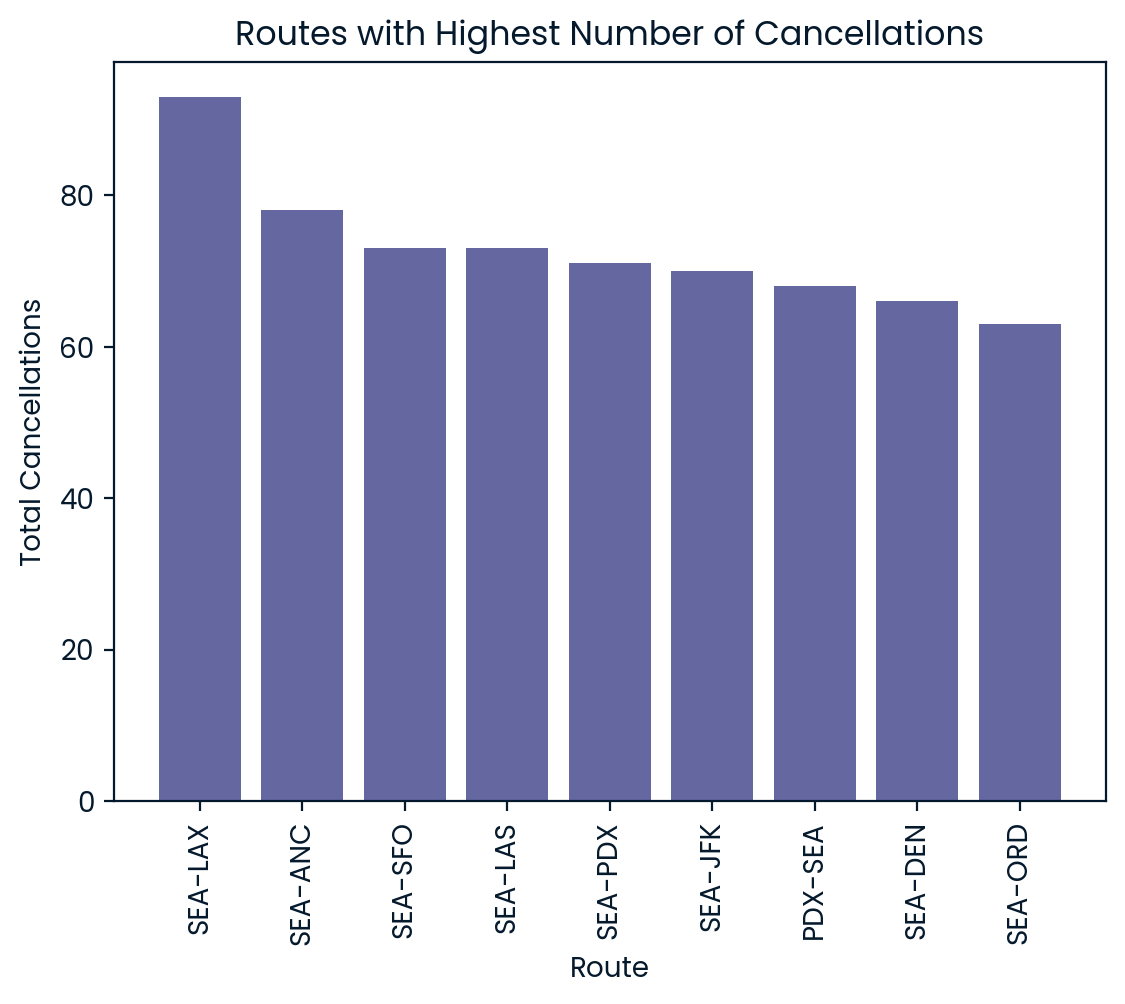

In [53]:
top9_route_cancels_bar, ax = plt.subplots()
ax.bar(top_routes_by_cancellations["route"], top_routes_by_cancellations["total_cancellations"])
ax.set_xlabel("Route")
ax.set_ylabel("Total Cancellations")
ax.set_title("Routes with Highest Number of Cancellations")
ax.set_xticklabels(top_routes_by_cancellations["route"], rotation=90)
plt.show()
plt.close()


In [54]:
#Identifying whether larger wind gusts contribute to bigger delays
# Are departure delays impacted by 10+ mph winds from each airport
df2["group"] = df2["wind_gust"].apply(lambda x: ">= 10mph" if x >= 10 else "< 10 mph")
wind_grouped_data = df2.groupby(["group", "origin"]).agg(mean_dep_delay=("dep_delay", "mean"))
print(wind_grouped_data)

wind_response = True

                 mean_dep_delay
group    origin                
< 10 mph PDX           6.686966
         SEA           7.857595
>= 10mph PDX           9.147024
         SEA           9.231060
